In [1]:
import pandas as pd
import numpy as np
from struct import unpack
from base64 import b64decode
import string
import random

In [220]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Activation, Dropout, concatenate, BatchNormalization, Multiply, Add, Lambda
from keras.callbacks import EarlyStopping
from keras.utils.np_utils import to_categorical

In [3]:
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler, normalize, StandardScaler
from sklearn.model_selection import train_test_split

In [4]:
IMG_LEN = 1024
TXT_LEN = 300
N_CLASSES = 50

### Data preparation

In [5]:
filename = "/Users/dmitry/Downloads/topics_dataset.json"
df = pd.read_json(filename, lines=True)

In [6]:
from functools import partial

def unpck(l, x):
    return unpack('%df' % l, b64decode(x.encode('utf-8')))

unpck_img = partial(unpck, IMG_LEN)
unpck_txt = partial(unpck, TXT_LEN)

In [101]:
x_img = np.stack(df['x1'].map(unpck_img), axis=0)
x_txt = np.stack(df['x2'].map(unpck_txt), axis=0)
y = to_categorical(np.array(df['y1']), N_CLASSES)

In [104]:
x_img_train, x_img_test, x_txt_train, x_txt_test, y_train, y_test = train_test_split(
    x_img, 
    x_txt, 
    y, 
    test_size=0.2, 
    random_state=42
)

In [105]:
x_img_train, x_img_val, x_txt_train, x_txt_val, y_train, y_val = train_test_split(
    x_img_train,
    x_txt_train,
    y_train,
    test_size=0.2,
    random_state=42
)

In [106]:
img_sscaler = StandardScaler()
img_sscaler.fit(x_img_train)

x_img_train = img_sscaler.transform(x_img_train)
x_img_val = img_sscaler.transform(x_img_val)
x_img_test = img_sscaler.transform(x_img_test)

txt_sscaler = StandardScaler()
txt_sscaler.fit(x_txt_train)

x_txt_train = txt_sscaler.transform(x_txt_train)
x_txt_val = txt_sscaler.transform(x_txt_val)
x_txt_test = txt_sscaler.transform(x_txt_test)

### Extracting 47th class

In [109]:
y_train_47 = y_train[:, 47]
y_val_47 = y_val[:, 47]
y_test_47 = y_test[:, 47]

In [ ]:
def show_stat(y):
    stat = {}
    for i in range(y.shape[0]):
        p = np.argmax(y[i])
        if p in test_stat:
            test_stat[p] += 1
        else:
            test_stat[p] = 1
        
    for key, value in sorted(test_stat.items()):
        print("{} : {}".format(key, value))

In [110]:
neg_train, pos_train = np.bincount(y_train_47.astype(np.int))
total_train = neg_train + pos_train
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total_train, pos_train, 100 * pos_train / total_train))

Examples:
    Total: 135897
    Positive: 340 (0.25% of total)



In [111]:
neg_val, pos_val = np.bincount(y_val_47.astype(np.int))
total_val = neg_val + pos_val
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total_val, pos_val, 100 * pos_val / total_val))

Examples:
    Total: 33975
    Positive: 65 (0.19% of total)



In [112]:
neg_test, pos_test = np.bincount(y_test_47.astype(np.int))
total_test = neg_test + pos_test
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total_test, pos_test, 100 * pos_test / total_test))

Examples:
    Total: 42468
    Positive: 98 (0.23% of total)



In [117]:
np.array([3, 4, 5])[np.array([1, 0, 1]).astype(bool)]

array([3, 5])

In [118]:
# select 47th rows
x_img_train_47 = x_img_train[y_train_47.astype(bool)]
x_txt_train_47 = x_txt_train[y_train_47.astype(bool)]

x_img_train_others = x_img_train[(y_train_47 - 1).astype(bool)]
x_txt_train_others = x_txt_train[(y_train_47 - 1).astype(bool)]

In [123]:
deviations_47 = np.std(x_img_train_47, axis=0) 

In [124]:
deviations_others = np.std(x_img_train_others, axis=0)

In [125]:
deviations_47

array([0.96118451, 0.91084354, 0.98085979, ..., 0.98485636, 1.00395001,
       0.93173016])

In [126]:
deviations_others

array([1.00009247, 1.0002125 , 1.00003889, ..., 1.00003222, 0.99998996,
       1.00016476])

In [129]:
deviations_difs = np.abs(deviations_47 - deviations_others)

In [131]:
np.argmax(deviations_difs)

111

In [133]:
deviations_difs[111]

0.38178755483435567

In [138]:
top_50 = np.argpartition(deviations_difs, -50, axis=0)[-50:]

In [139]:
x_img_train_top_50 = x_img_train[:, top_50]
x_img_val_top_50 = x_img_val[:, top_50]
x_img_test_top_50 = x_img_test[:, top_50]

In [140]:
x_img_train_top_50.shape

(135897, 50)

In [145]:
def get_model_img():
    inp_img = Input(shape=(1024,))
    x = Dense(64, activation='relu')(inp_img)
    x = Dropout(0.5)(x)
    x = Dense(64)(x)
    x = Dropout(0.5)(x)
    out = Dense(1, activation='sigmoid')(x)

    model = Model(inputs = inp_img, outputs=out)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=METRICS)
    return model

In [156]:
model_img = get_model_img()
model_img.fit(
    x_img_train, 
    y_train_47, 
    validation_data=(x_img_val, y_val_47), 
    class_weight={0: 0.05, 1: 0.95}, 
    epochs=60,
    batch_size=2048
)

Train on 135897 samples, validate on 33975 samples
Epoch 1/60
135897/135897 [==============================] - 11s 79us/sample - loss: 0.0187 - tp: 25.0000 - fp: 7794.0000 - tn: 127763.0000 - fn: 315.0000 - accuracy: 0.9403 - precision: 0.0032 - recall: 0.0735 - auc: 0.5308 - val_loss: 0.0085 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 33910.0000 - val_fn: 65.0000 - val_accuracy: 0.9981 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6148
Epoch 2/60
135897/135897 [==============================] - 3s 23us/sample - loss: 0.0122 - tp: 7.0000 - fp: 1428.0000 - tn: 134129.0000 - fn: 333.0000 - accuracy: 0.9870 - precision: 0.0049 - recall: 0.0206 - auc: 0.6073 - val_loss: 0.0082 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 33910.0000 - val_fn: 65.0000 - val_accuracy: 0.9981 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6357
Epoch 3/60
135897/135897 [==============================] - 3s 23us/sample - loss: 0.0111 - tp: 5.0000 - fp: 729.00

Epoch 21/60
135897/135897 [==============================] - 3s 24us/sample - loss: 0.0054 - tp: 92.0000 - fp: 690.0000 - tn: 134867.0000 - fn: 248.0000 - accuracy: 0.9931 - precision: 0.1176 - recall: 0.2706 - auc: 0.9339 - val_loss: 0.0114 - val_tp: 1.0000 - val_fp: 4.0000 - val_tn: 33906.0000 - val_fn: 64.0000 - val_accuracy: 0.9980 - val_precision: 0.2000 - val_recall: 0.0154 - val_auc: 0.5489
Epoch 22/60
135897/135897 [==============================] - 3s 22us/sample - loss: 0.0049 - tp: 112.0000 - fp: 678.0000 - tn: 134879.0000 - fn: 228.0000 - accuracy: 0.9933 - precision: 0.1418 - recall: 0.3294 - auc: 0.9476 - val_loss: 0.0119 - val_tp: 1.0000 - val_fp: 4.0000 - val_tn: 33906.0000 - val_fn: 64.0000 - val_accuracy: 0.9980 - val_precision: 0.2000 - val_recall: 0.0154 - val_auc: 0.5614
Epoch 23/60
135897/135897 [==============================] - 3s 21us/sample - loss: 0.0047 - tp: 133.0000 - fp: 687.0000 - tn: 134870.0000 - fn: 207.0000 - accuracy: 0.9934 - precision: 0.1622 - re

135897/135897 [==============================] - 3s 21us/sample - loss: 0.0027 - tp: 249.0000 - fp: 691.0000 - tn: 134866.0000 - fn: 91.0000 - accuracy: 0.9942 - precision: 0.2649 - recall: 0.7324 - auc: 0.9790 - val_loss: 0.0211 - val_tp: 1.0000 - val_fp: 14.0000 - val_tn: 33896.0000 - val_fn: 64.0000 - val_accuracy: 0.9977 - val_precision: 0.0667 - val_recall: 0.0154 - val_auc: 0.5057
Epoch 42/60
135897/135897 [==============================] - 3s 22us/sample - loss: 0.0026 - tp: 255.0000 - fp: 712.0000 - tn: 134845.0000 - fn: 85.0000 - accuracy: 0.9941 - precision: 0.2637 - recall: 0.7500 - auc: 0.9792 - val_loss: 0.0217 - val_tp: 1.0000 - val_fp: 14.0000 - val_tn: 33896.0000 - val_fn: 64.0000 - val_accuracy: 0.9977 - val_precision: 0.0667 - val_recall: 0.0154 - val_auc: 0.4733
Epoch 43/60
135897/135897 [==============================] - 3s 21us/sample - loss: 0.0024 - tp: 261.0000 - fp: 562.0000 - tn: 134995.0000 - fn: 79.0000 - accuracy: 0.9953 - precision: 0.3171 - recall: 0.7676

In [149]:
def get_model_txt():
    inp_txt = Input(shape=(300,))
    x = Dense(64, activation='relu')(inp_txt)
    x = Dropout(0.5)(x)
    x = Dense(64)(x)
    x = Dropout(0.5)(x)
    out = Dense(1, activation='sigmoid')(x)

    model = Model(inputs = inp_txt, outputs=out)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=METRICS)
    return model

In [154]:
model_txt = get_model_txt()
model_txt.fit(
    x_txt_train, 
    y_train_47, 
    validation_data=(x_txt_val, y_val_47), 
    class_weight={0: 0.05, 1: 0.95}, 
    epochs=60,
    batch_size=2048
)

Train on 135897 samples, validate on 33975 samples
Epoch 1/60
135897/135897 [==============================] - 5s 36us/sample - loss: 0.0177 - tp: 15.0000 - fp: 6862.0000 - tn: 128695.0000 - fn: 325.0000 - accuracy: 0.9471 - precision: 0.0022 - recall: 0.0441 - auc: 0.5249 - val_loss: 0.0082 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 33910.0000 - val_fn: 65.0000 - val_accuracy: 0.9981 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6297
Epoch 2/60
135897/135897 [==============================] - 2s 15us/sample - loss: 0.0119 - tp: 3.0000 - fp: 1047.0000 - tn: 134510.0000 - fn: 337.0000 - accuracy: 0.9898 - precision: 0.0029 - recall: 0.0088 - auc: 0.6113 - val_loss: 0.0079 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 33910.0000 - val_fn: 65.0000 - val_accuracy: 0.9981 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6663
Epoch 3/60
135897/135897 [==============================] - 2s 15us/sample - loss: 0.0107 - tp: 3.0000 - fp: 533.000

Epoch 21/60
135897/135897 [==============================] - 2s 13us/sample - loss: 0.0055 - tp: 86.0000 - fp: 418.0000 - tn: 135139.0000 - fn: 254.0000 - accuracy: 0.9951 - precision: 0.1706 - recall: 0.2529 - auc: 0.9330 - val_loss: 0.0097 - val_tp: 0.0000e+00 - val_fp: 5.0000 - val_tn: 33905.0000 - val_fn: 65.0000 - val_accuracy: 0.9979 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6527
Epoch 22/60
135897/135897 [==============================] - 2s 11us/sample - loss: 0.0054 - tp: 88.0000 - fp: 405.0000 - tn: 135152.0000 - fn: 252.0000 - accuracy: 0.9952 - precision: 0.1785 - recall: 0.2588 - auc: 0.9375 - val_loss: 0.0102 - val_tp: 1.0000 - val_fp: 5.0000 - val_tn: 33905.0000 - val_fn: 64.0000 - val_accuracy: 0.9980 - val_precision: 0.1667 - val_recall: 0.0154 - val_auc: 0.6412
Epoch 23/60
135897/135897 [==============================] - 1s 11us/sample - loss: 0.0054 - tp: 89.0000 - fp: 466.0000 - tn: 135091.0000 - fn: 251.0000 - accuracy: 0.9947 - precision: 0

135897/135897 [==============================] - 1s 11us/sample - loss: 0.0033 - tp: 211.0000 - fp: 634.0000 - tn: 134923.0000 - fn: 129.0000 - accuracy: 0.9944 - precision: 0.2497 - recall: 0.6206 - auc: 0.9737 - val_loss: 0.0177 - val_tp: 1.0000 - val_fp: 20.0000 - val_tn: 33890.0000 - val_fn: 64.0000 - val_accuracy: 0.9975 - val_precision: 0.0476 - val_recall: 0.0154 - val_auc: 0.5524
Epoch 42/60
135897/135897 [==============================] - 1s 10us/sample - loss: 0.0032 - tp: 241.0000 - fp: 607.0000 - tn: 134950.0000 - fn: 99.0000 - accuracy: 0.9948 - precision: 0.2842 - recall: 0.7088 - auc: 0.9745 - val_loss: 0.0187 - val_tp: 1.0000 - val_fp: 19.0000 - val_tn: 33891.0000 - val_fn: 64.0000 - val_accuracy: 0.9976 - val_precision: 0.0500 - val_recall: 0.0154 - val_auc: 0.5536
Epoch 43/60
135897/135897 [==============================] - 1s 10us/sample - loss: 0.0033 - tp: 236.0000 - fp: 602.0000 - tn: 134955.0000 - fn: 104.0000 - accuracy: 0.9948 - precision: 0.2816 - recall: 0.69

In [143]:
def get_model_img_top_50():
    inp_img = Input(shape=(50,))
    x = Dense(64, activation='relu')(inp_img)
    x = Dropout(0.5)(x)
    x = Dense(64)(x)
    x = Dropout(0.5)(x)
    out = Dense(1, activation='sigmoid')(x)

    model = Model(inputs = inp_img, outputs=out)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=METRICS)
    return model

In [152]:
model_img_top_50 = get_model_img_top_50()
model_img_top_50.fit(
    x_img_train_top_50, 
    y_train_47, 
    validation_data=(x_img_val_top_50, y_val_47), 
    class_weight={0: 0.05, 1: 0.95}, 
    epochs=20,
    batch_size=2048
)

Train on 135897 samples, validate on 33975 samples
Epoch 1/20
135897/135897 [==============================] - 4s 27us/sample - loss: 0.0162 - tp: 9.0000 - fp: 5211.0000 - tn: 130346.0000 - fn: 331.0000 - accuracy: 0.9592 - precision: 0.0017 - recall: 0.0265 - auc: 0.4956 - val_loss: 0.0086 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 33910.0000 - val_fn: 65.0000 - val_accuracy: 0.9981 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5373
Epoch 2/20
135897/135897 [==============================] - 1s 7us/sample - loss: 0.0121 - tp: 0.0000e+00 - fp: 474.0000 - tn: 135083.0000 - fn: 340.0000 - accuracy: 0.9940 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5442 - val_loss: 0.0084 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 33910.0000 - val_fn: 65.0000 - val_accuracy: 0.9981 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5504
Epoch 3/20
135897/135897 [==============================] - 1s 7us/sample - loss: 0.0116 - tp: 1.0000 - fp:

135897/135897 [==============================] - 1s 6us/sample - loss: 0.0095 - tp: 0.0000e+00 - fp: 1.0000 - tn: 135556.0000 - fn: 340.0000 - accuracy: 0.9975 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6701 - val_loss: 0.0081 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 33910.0000 - val_fn: 65.0000 - val_accuracy: 0.9981 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5876


In [31]:
METRICS = [
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'), 
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
]

In [45]:
METRICS_NAMES = [
    'tp',
    'fp',
    'tn',
    'fn',
    'accuracy',
    'precision',
    'recall',
    'auc'
]

In [51]:
def get_model_class_47():
    inp_img = Input(shape=(1024,))
    x_img = Dense(512, activation='relu')(inp_img)
    x_img = Dropout(0.5)(x_img)
    
    inp_txt = Input(shape=(300,))
    x_txt = Dense(256, activation='relu')(inp_txt)
    x_txt = Dropout(0.5)(x_txt)
    
    x = concatenate([x_img, x_txt])
    x = Dense(64)(x)
    x = Dropout(0.5)(x)
    out = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=[inp_img, inp_txt], outputs=out)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=METRICS)
    return model

In [223]:
model_47 = get_model_class_47()
model_47.fit(
    [x_img_train, x_txt_train], 
    y_train_47, 
    epochs=30, 
    validation_data=([x_img_val, x_txt_val], y_val_47), 
    batch_size=4096
)

Train on 135897 samples, validate on 33975 samples
Epoch 1/30
135897/135897 [==============================] - 19s 143us/sample - loss: 0.0823 - tp: 6.0000 - fp: 1880.0000 - tn: 133677.0000 - fn: 334.0000 - accuracy: 0.9837 - precision: 0.0032 - recall: 0.0176 - auc: 0.5044 - val_loss: 0.0425 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 33910.0000 - val_fn: 65.0000 - val_accuracy: 0.9981 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5000
Epoch 2/30
135897/135897 [==============================] - 8s 57us/sample - loss: 0.0407 - tp: 0.0000e+00 - fp: 4.0000 - tn: 135553.0000 - fn: 340.0000 - accuracy: 0.9975 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5004 - val_loss: 0.0245 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 33910.0000 - val_fn: 65.0000 - val_accuracy: 0.9981 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5263
Epoch 3/30
135897/135897 [==============================] - 8s 55us/sample - loss: 0.0249 - tp: 0.0000e+00

Epoch 21/30
135897/135897 [==============================] - 9s 68us/sample - loss: 0.0059 - tp: 149.0000 - fp: 23.0000 - tn: 135534.0000 - fn: 191.0000 - accuracy: 0.9984 - precision: 0.8663 - recall: 0.4382 - auc: 0.9568 - val_loss: 0.0205 - val_tp: 1.0000 - val_fp: 1.0000 - val_tn: 33909.0000 - val_fn: 64.0000 - val_accuracy: 0.9981 - val_precision: 0.5000 - val_recall: 0.0154 - val_auc: 0.5416
Epoch 22/30
135897/135897 [==============================] - 9s 67us/sample - loss: 0.0061 - tp: 143.0000 - fp: 36.0000 - tn: 135521.0000 - fn: 197.0000 - accuracy: 0.9983 - precision: 0.7989 - recall: 0.4206 - auc: 0.9537 - val_loss: 0.0216 - val_tp: 1.0000 - val_fp: 1.0000 - val_tn: 33909.0000 - val_fn: 64.0000 - val_accuracy: 0.9981 - val_precision: 0.5000 - val_recall: 0.0154 - val_auc: 0.5267
Epoch 23/30
135897/135897 [==============================] - 9s 66us/sample - loss: 0.0054 - tp: 170.0000 - fp: 23.0000 - tn: 135534.0000 - fn: 170.0000 - accuracy: 0.9986 - precision: 0.8808 - reca

In [35]:
y_pred_47 = model_47.predict([x_img_test, x_txt_test])
print(classification_report(np.argmax(y_pred_47, axis=1), y_test_class_47))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     42468
         1.0       0.00      0.00      0.00         0

    accuracy                           1.00     42468
   macro avg       0.50      0.50      0.50     42468
weighted avg       1.00      1.00      1.00     42468



In [36]:
max(y_pred_47)

array([0.9885339], dtype=float32)

In [37]:
np.unique(y_pred_47)

array([1.8265843e-04, 2.2479892e-04, 2.3168325e-04, ..., 9.7869611e-01,
       9.8012865e-01, 9.8853391e-01], dtype=float32)

In [38]:
labels_47 = (y_pred_47 < 0.5).astype(np.int)

In [39]:
np.unique(labels_47)

array([0, 1])

In [40]:
print(classification_report(np.argmax(labels_47, axis=1), y_test_class_47))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     42468
         1.0       0.00      0.00      0.00         0

    accuracy                           1.00     42468
   macro avg       0.50      0.50      0.50     42468
weighted avg       1.00      1.00      1.00     42468



In [42]:
sum((labels_47 == 0).astype(np.int))

array([3381])

In [63]:
ev = model_47.evaluate([x_img_test, x_txt_test], y_test_class_47, verbose=0)


In [54]:
print(METRICS_NAMES)

['tp', 'fp', 'tn', 'fn', 'accuracy', 'precision', 'recall', 'auc']


In [64]:
print(ev)

[0.027148785302560777, 1.0, 64.0, 42305.0, 98.0, 0.99618536, 0.015384615, 0.01010101, 0.5595725]


In [58]:
neg, pos = np.bincount(y_train_class_47.astype(np.int))
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 169872
    Positive: 404 (0.24% of total)



In [76]:
pos = np.bincount(y_train_class_47.astype(np.int))[1]
neg = len(y_train) - pos
init_bias = np.log([pos / neg])

In [80]:
init_bias

array([-6.03900452])

In [157]:
def get_model_class_47_1():
    output_bias = tf.keras.initializers.Constant(init_bias)
    
    inp_img = Input(shape=(1024,))
    x_img = Dense(512, activation='relu')(inp_img)
    x_img = Dropout(0.5)(x_img)
    
    inp_txt = Input(shape=(300,))
    x_txt = Dense(256, activation='relu')(inp_txt)
    x_txt = Dropout(0.5)(x_txt)
    
    x = concatenate([x_img, x_txt])
    x = Dense(64)(x)
    x = Dropout(0.5)(x)
    out = Dense(1, activation='sigmoid',  bias_initializer=output_bias)(x)

    model = Model(inputs=[inp_img, inp_txt], outputs=out)
    model.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-3), loss='binary_crossentropy', metrics=METRICS)
    return model

In [160]:
model_47_1 = get_model_class_47_1()
history_1 = model_47_1.fit(
    [x_img_train, x_txt_train], 
    y_train_47, 
    epochs=30, 
    validation_data=([x_img_val, x_txt_val], y_val_47), 
    batch_size=4096
)

Train on 135897 samples, validate on 33975 samples
Epoch 1/30
135897/135897 [==============================] - 22s 163us/sample - loss: 0.0542 - tp: 1.0000 - fp: 271.0000 - tn: 135286.0000 - fn: 339.0000 - accuracy: 0.9955 - precision: 0.0037 - recall: 0.0029 - auc: 0.4989 - val_loss: 0.0280 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 33910.0000 - val_fn: 65.0000 - val_accuracy: 0.9981 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5053
Epoch 2/30
135897/135897 [==============================] - 9s 65us/sample - loss: 0.0252 - tp: 0.0000e+00 - fp: 64.0000 - tn: 135493.0000 - fn: 340.0000 - accuracy: 0.9970 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5524 - val_loss: 0.0159 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 33910.0000 - val_fn: 65.0000 - val_accuracy: 0.9981 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5275
Epoch 3/30
135897/135897 [==============================] - 7s 51us/sample - loss: 0.0197 - tp: 4.0000 - f

Epoch 21/30
135897/135897 [==============================] - 10s 72us/sample - loss: 0.0055 - tp: 185.0000 - fp: 44.0000 - tn: 135513.0000 - fn: 155.0000 - accuracy: 0.9985 - precision: 0.8079 - recall: 0.5441 - auc: 0.9555 - val_loss: 0.0247 - val_tp: 1.0000 - val_fp: 2.0000 - val_tn: 33908.0000 - val_fn: 64.0000 - val_accuracy: 0.9981 - val_precision: 0.3333 - val_recall: 0.0154 - val_auc: 0.5359
Epoch 22/30
135897/135897 [==============================] - 9s 69us/sample - loss: 0.0047 - tp: 207.0000 - fp: 46.0000 - tn: 135511.0000 - fn: 133.0000 - accuracy: 0.9987 - precision: 0.8182 - recall: 0.6088 - auc: 0.9733 - val_loss: 0.0266 - val_tp: 1.0000 - val_fp: 1.0000 - val_tn: 33909.0000 - val_fn: 64.0000 - val_accuracy: 0.9981 - val_precision: 0.5000 - val_recall: 0.0154 - val_auc: 0.5369
Epoch 23/30
135897/135897 [==============================] - 10s 73us/sample - loss: 0.0049 - tp: 197.0000 - fp: 43.0000 - tn: 135514.0000 - fn: 143.0000 - accuracy: 0.9986 - precision: 0.8208 - re

In [161]:
history_1 = model_47_1.fit(
    [x_img_train, x_txt_train], 
    y_train_47, 
    epochs=30, 
    validation_data=([x_img_val, x_txt_val], y_val_47), 
    batch_size=4096
)

Train on 135897 samples, validate on 33975 samples
Epoch 1/30
135897/135897 [==============================] - 8s 59us/sample - loss: 0.0027 - tp: 265.0000 - fp: 34.0000 - tn: 135523.0000 - fn: 75.0000 - accuracy: 0.9992 - precision: 0.8863 - recall: 0.7794 - auc: 0.9804 - val_loss: 0.0319 - val_tp: 1.0000 - val_fp: 2.0000 - val_tn: 33908.0000 - val_fn: 64.0000 - val_accuracy: 0.9981 - val_precision: 0.3333 - val_recall: 0.0154 - val_auc: 0.5296
Epoch 2/30
135897/135897 [==============================] - 7s 55us/sample - loss: 0.0027 - tp: 270.0000 - fp: 34.0000 - tn: 135523.0000 - fn: 70.0000 - accuracy: 0.9992 - precision: 0.8882 - recall: 0.7941 - auc: 0.9790 - val_loss: 0.0323 - val_tp: 1.0000 - val_fp: 2.0000 - val_tn: 33908.0000 - val_fn: 64.0000 - val_accuracy: 0.9981 - val_precision: 0.3333 - val_recall: 0.0154 - val_auc: 0.5146
Epoch 3/30
135897/135897 [==============================] - 10s 71us/sample - loss: 0.0025 - tp: 271.0000 - fp: 28.0000 - tn: 135529.0000 - fn: 69.0000

135897/135897 [==============================] - 10s 71us/sample - loss: 0.0016 - tp: 294.0000 - fp: 21.0000 - tn: 135536.0000 - fn: 46.0000 - accuracy: 0.9995 - precision: 0.9333 - recall: 0.8647 - auc: 0.9881 - val_loss: 0.0387 - val_tp: 1.0000 - val_fp: 3.0000 - val_tn: 33907.0000 - val_fn: 64.0000 - val_accuracy: 0.9980 - val_precision: 0.2500 - val_recall: 0.0154 - val_auc: 0.5223
Epoch 22/30
135897/135897 [==============================] - 9s 70us/sample - loss: 0.0017 - tp: 295.0000 - fp: 17.0000 - tn: 135540.0000 - fn: 45.0000 - accuracy: 0.9995 - precision: 0.9455 - recall: 0.8676 - auc: 0.9910 - val_loss: 0.0379 - val_tp: 1.0000 - val_fp: 4.0000 - val_tn: 33906.0000 - val_fn: 64.0000 - val_accuracy: 0.9980 - val_precision: 0.2000 - val_recall: 0.0154 - val_auc: 0.5222
Epoch 23/30
135897/135897 [==============================] - 9s 67us/sample - loss: 0.0015 - tp: 297.0000 - fp: 16.0000 - tn: 135541.0000 - fn: 43.0000 - accuracy: 0.9996 - precision: 0.9489 - recall: 0.8735 - a

In [163]:
model_47_1_1 = get_model_class_47_1()
history_1_1 = model_47_1_1.fit(
    [x_img_train, x_txt_train], 
    y_train_47, 
    epochs=30, 
    validation_data=([x_img_val, x_txt_val], y_val_47), 
    batch_size=2048
)

Train on 135897 samples, validate on 33975 samples
Epoch 1/30
135897/135897 [==============================] - 12s 87us/sample - loss: 0.0342 - tp: 2.0000 - fp: 123.0000 - tn: 135434.0000 - fn: 338.0000 - accuracy: 0.9966 - precision: 0.0160 - recall: 0.0059 - auc: 0.5264 - val_loss: 0.0158 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 33910.0000 - val_fn: 65.0000 - val_accuracy: 0.9981 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5194
Epoch 2/30
135897/135897 [==============================] - 8s 58us/sample - loss: 0.0214 - tp: 1.0000 - fp: 31.0000 - tn: 135526.0000 - fn: 339.0000 - accuracy: 0.9973 - precision: 0.0312 - recall: 0.0029 - auc: 0.5802 - val_loss: 0.0146 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 33910.0000 - val_fn: 65.0000 - val_accuracy: 0.9981 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5362
Epoch 3/30
135897/135897 [==============================] - 8s 61us/sample - loss: 0.0194 - tp: 0.0000e+00 - fp: 31.000

Epoch 21/30
135897/135897 [==============================] - 11s 82us/sample - loss: 0.0043 - tp: 217.0000 - fp: 39.0000 - tn: 135518.0000 - fn: 123.0000 - accuracy: 0.9988 - precision: 0.8477 - recall: 0.6382 - auc: 0.9707 - val_loss: 0.0253 - val_tp: 1.0000 - val_fp: 3.0000 - val_tn: 33907.0000 - val_fn: 64.0000 - val_accuracy: 0.9980 - val_precision: 0.2500 - val_recall: 0.0154 - val_auc: 0.5196
Epoch 22/30
135897/135897 [==============================] - 11s 82us/sample - loss: 0.0035 - tp: 243.0000 - fp: 28.0000 - tn: 135529.0000 - fn: 97.0000 - accuracy: 0.9991 - precision: 0.8967 - recall: 0.7147 - auc: 0.9813 - val_loss: 0.0263 - val_tp: 1.0000 - val_fp: 3.0000 - val_tn: 33907.0000 - val_fn: 64.0000 - val_accuracy: 0.9980 - val_precision: 0.2500 - val_recall: 0.0154 - val_auc: 0.5214
Epoch 23/30
135897/135897 [==============================] - 11s 81us/sample - loss: 0.0032 - tp: 252.0000 - fp: 26.0000 - tn: 135531.0000 - fn: 88.0000 - accuracy: 0.9992 - precision: 0.9065 - rec

In [88]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
import warnings

from tensorflow.keras.layers import Layer, InputSpec
from tensorflow.keras import backend as K
from tensorflow.python.keras.utils import conv_utils
from tensorflow.python.keras.utils.generic_utils import to_list
from  tensorflow.keras import regularizers 
from tensorflow.keras import constraints
from tensorflow.keras import activations
from tensorflow.keras import initializers

class Highway(Layer):
    """Densely connected highway network.
    Highway layers are a natural extension of LSTMs to feedforward networks.
    # Arguments
        init: name of initialization function for the weights of the layer
            (see [initializations](../initializations.md)),
            or alternatively, Theano function to use for weights
            initialization. This parameter is only relevant
            if you don't pass a `weights` argument.
        activation: name of activation function to use
            (see [activations](../activations.md)),
            or alternatively, elementwise Theano function.
            If you don't specify anything, no activation is applied
            (ie. "linear" activation: a(x) = x).
        weights: list of Numpy arrays to set as initial weights.
            The list should have 2 elements, of shape `(input_dim, output_dim)`
            and (output_dim,) for weights and biases respectively.
        W_regularizer: instance of [WeightRegularizer](../regularizers.md)
            (eg. L1 or L2 regularization), applied to the main weights matrix.
        b_regularizer: instance of [WeightRegularizer](../regularizers.md),
            applied to the bias.
        activity_regularizer: instance of [ActivityRegularizer](../regularizers.md),
            applied to the network output.
        W_constraint: instance of the [constraints](../constraints.md) module
            (eg. maxnorm, nonneg), applied to the main weights matrix.
        b_constraint: instance of the [constraints](../constraints.md) module,
            applied to the bias.
        bias: whether to include a bias
            (i.e. make the layer affine rather than linear).
        input_dim: dimensionality of the input (integer). This argument
            (or alternatively, the keyword argument `input_shape`)
            is required when using this layer as the first layer in a model.
    # Input shape
        2D tensor with shape: `(nb_samples, input_dim)`.
    # Output shape
        2D tensor with shape: `(nb_samples, input_dim)`.
    # References
        - [Highway Networks](http://arxiv.org/abs/1505.00387v2)
    """

    def __init__(self,
                 init='glorot_uniform',
                 activation=None,
                 weights=None,
                 W_regularizer=None,
                 b_regularizer=None,
                 activity_regularizer=None,
                 W_constraint=None,
                 b_constraint=None,
                 bias=True,
                 input_dim=None,
                 **kwargs):
        
        if 'transform_bias' in kwargs:
            kwargs.pop('transform_bias')
            warnings.warn('`transform_bias` argument is deprecated and '
                          'has been removed.')
        self.init = initializers.get(init)
        self.activation = activations.get(activation)

        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)
        self.activity_regularizer = regularizers.get(activity_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        self.initial_weights = weights
        self.input_spec = InputSpec(ndim=2)

        self.input_dim = input_dim
        if self.input_dim:
            kwargs['input_shape'] = (self.input_dim,)
        super(Highway, self).__init__(**kwargs)

    def build(self, input_shape):
        input_dim = input_shape[1]
        self.input_spec = InputSpec(dtype=K.floatx(),
                                    shape=(None, input_dim))

        self.W = self.add_weight(shape=(input_dim, input_dim),
                                 initializer=self.init,
                                 name='W',
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.W_carry = self.add_weight(shape=(input_dim, input_dim),
                                       initializer=self.init,
                                       name='W_carry')
        if self.bias:
            self.b = self.add_weight(shape=(input_dim,),
                                     initializer='zero',
                                     name='b',
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
            self.b_carry = self.add_weight(shape=(input_dim,),
                                           initializer='one',
                                           name='b_carry')
        else:
            self.b_carry = None

        if self.initial_weights is not None:
            self.set_weights(self.initial_weights)
            del self.initial_weights
        self.built = True

    def call(self, x):
        y = K.dot(x, self.W_carry)
        if self.bias:
            y += self.b_carry
        transform_weight = activations.sigmoid(y)
        y = K.dot(x, self.W)
        if self.bias:
            y += self.b
        act = self.activation(y)
        act *= transform_weight
        output = act + (1 - transform_weight) * x
        return output

    def get_config(self):
        config = {'init': initializers.serialize(self.init),
                  'activation': activations.serialize(self.activation),
                  'W_regularizer': regularizers.serialize(self.W_regularizer),
                  'b_regularizer': regularizers.serialize(self.b_regularizer),
                  'activity_regularizer':
                      regularizers.serialize(self.activity_regularizer),
                  'W_constraint': constraints.serialize(self.W_constraint),
                  'b_constraint': constraints.serialize(self.b_constraint),
                  'bias': self.bias,
                  'input_dim': self.input_dim}
        base_config = super(Highway, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [89]:
def get_model_47_highway():
    output_bias = tf.keras.initializers.Constant(init_bias)
    
    inp_img = Input(shape=(1024,))
    x_img = Dense(512, activation='relu')(inp_img)
    x_img = Dropout(0.5)(x_img)
    
    inp_txt = Input(shape=(300,))
    x_txt = Dense(256, activation='relu')(inp_txt)
    x_txt = Dropout(0.5)(x_txt)
    
    x = concatenate([x_img, x_txt])
    x = Highway()(x)
    x = Dropout(0.5)(x)
    x = Highway()(x)
    x = Dropout(0.5)(x)
    out = Dense(1, activation='sigmoid',  bias_initializer=output_bias)(x)

    model = Model(inputs=[inp_img, inp_txt], outputs=out)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=METRICS)
    return model

In [224]:
model_47_highway = get_model_47_highway()
history_highway = model_47_highway.fit(
    [x_img_train, x_txt_train], 
    y_train_47, 
    epochs=30, 
    validation_data=([x_img_val, x_txt_val], y_val_47), 
    batch_size=2048
)

Train on 135897 samples, validate on 33975 samples
Epoch 1/30
135897/135897 [==============================] - 49s 363us/sample - loss: 0.0259 - tp: 0.0000e+00 - fp: 60.0000 - tn: 135497.0000 - fn: 340.0000 - accuracy: 0.9971 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5194 - val_loss: 0.0165 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 33910.0000 - val_fn: 65.0000 - val_accuracy: 0.9981 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5069
Epoch 2/30
135897/135897 [==============================] - 42s 307us/sample - loss: 0.0210 - tp: 0.0000e+00 - fp: 12.0000 - tn: 135545.0000 - fn: 340.0000 - accuracy: 0.9974 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5529 - val_loss: 0.0145 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 33910.0000 - val_fn: 65.0000 - val_accuracy: 0.9981 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5332
Epoch 3/30
135897/135897 [==============================] - 43s 319us/sample - loss: 0.0184 -

Epoch 21/30
135897/135897 [==============================] - 39s 286us/sample - loss: 0.0056 - tp: 202.0000 - fp: 55.0000 - tn: 135502.0000 - fn: 138.0000 - accuracy: 0.9986 - precision: 0.7860 - recall: 0.5941 - auc: 0.9465 - val_loss: 0.0227 - val_tp: 1.0000 - val_fp: 3.0000 - val_tn: 33907.0000 - val_fn: 64.0000 - val_accuracy: 0.9980 - val_precision: 0.2500 - val_recall: 0.0154 - val_auc: 0.5147
Epoch 22/30
135897/135897 [==============================] - 40s 292us/sample - loss: 0.0055 - tp: 216.0000 - fp: 44.0000 - tn: 135513.0000 - fn: 124.0000 - accuracy: 0.9988 - precision: 0.8308 - recall: 0.6353 - auc: 0.9481 - val_loss: 0.0238 - val_tp: 1.0000 - val_fp: 2.0000 - val_tn: 33908.0000 - val_fn: 64.0000 - val_accuracy: 0.9981 - val_precision: 0.3333 - val_recall: 0.0154 - val_auc: 0.5227
Epoch 23/30
135897/135897 [==============================] - 39s 286us/sample - loss: 0.0057 - tp: 204.0000 - fp: 42.0000 - tn: 135515.0000 - fn: 136.0000 - accuracy: 0.9987 - precision: 0.8293 

### Trying upsample

In [164]:
x_img_train_47 = x_img_train[y_train_47.astype(bool)]
x_txt_train_47 = x_txt_train[y_train_47.astype(bool)]

x_img_train_others = x_img_train[(y_train_47 - 1).astype(bool)]
x_txt_train_others = x_txt_train[(y_train_47 - 1).astype(bool)]

In [166]:
n_47_samples = 5000

In [184]:
rep_coef = n_47_samples // x_img_train_47.shape[0]
x_img_train_47_up = np.repeat(x_img_train_47, rep_coef, axis=0)
x_txt_train_47_up = np.repeat(x_txt_train_47, rep_coef, axis=0)
y_train_47_up = np.ones(x_img_train_47_up.shape[0])

In [186]:
print(x_img_train_47.shape)
print(x_img_train_47_up.shape)
print(x_txt_train_47_up.shape)
print(y_train_47_up.shape)

(340, 1024)
(4760, 1024)
(4760, 300)
(4760,)


In [189]:
x_img_train_others.shape

(135557, 1024)

In [190]:
x_img_train_up = np.concatenate((x_img_train_others, x_img_train_47_up))
x_txt_train_up = np.concatenate((x_txt_train_others, x_txt_train_47_up))
y_train_up = np.concatenate((np.zeros(x_img_train_others.shape[0]), y_train_47_up))

In [191]:
perm = np.random.permutation(len(y_train_up))
x_img_train_up = x_img_train_up[perm]
x_txt_train_up = x_txt_train_up[perm]
y_train_up = y_train_up[perm]

In [192]:
model_up = get_model_class_47_1()
model_up.fit(
    [x_img_train_up, x_txt_train_up],
    y_train_up,
    batch_size=2048,
    validation_data=([x_img_val, x_txt_val], y_val_47),
    epochs=20
)

Train on 140317 samples, validate on 33975 samples
Epoch 1/20
140317/140317 [==============================] - 13s 91us/sample - loss: 0.1507 - tp: 744.0000 - fp: 1456.0000 - tn: 134101.0000 - fn: 4016.0000 - accuracy: 0.9610 - precision: 0.3382 - recall: 0.1563 - auc: 0.7788 - val_loss: 0.0178 - val_tp: 1.0000 - val_fp: 15.0000 - val_tn: 33895.0000 - val_fn: 64.0000 - val_accuracy: 0.9977 - val_precision: 0.0625 - val_recall: 0.0154 - val_auc: 0.5969
Epoch 2/20
140317/140317 [==============================] - 8s 60us/sample - loss: 0.0639 - tp: 2564.0000 - fp: 822.0000 - tn: 134735.0000 - fn: 2196.0000 - accuracy: 0.9785 - precision: 0.7572 - recall: 0.5387 - auc: 0.9592 - val_loss: 0.0197 - val_tp: 1.0000 - val_fp: 22.0000 - val_tn: 33888.0000 - val_fn: 64.0000 - val_accuracy: 0.9975 - val_precision: 0.0435 - val_recall: 0.0154 - val_auc: 0.5608
Epoch 3/20
140317/140317 [==============================] - 9s 62us/sample - loss: 0.0298 - tp: 3775.0000 - fp: 495.0000 - tn: 135062.0000 -

In [193]:
model_up.fit(
    [x_img_train_up, x_txt_train_up],
    y_train_up,
    batch_size=2048,
    validation_data=([x_img_val, x_txt_val], y_val_47),
    epochs=20
)

Train on 140317 samples, validate on 33975 samples
Epoch 1/20
140317/140317 [==============================] - 12s 82us/sample - loss: 0.0035 - tp: 4680.0000 - fp: 66.0000 - tn: 135491.0000 - fn: 80.0000 - accuracy: 0.9990 - precision: 0.9861 - recall: 0.9832 - auc: 0.9996 - val_loss: 0.0540 - val_tp: 1.0000 - val_fp: 6.0000 - val_tn: 33904.0000 - val_fn: 64.0000 - val_accuracy: 0.9979 - val_precision: 0.1429 - val_recall: 0.0154 - val_auc: 0.5069
Epoch 2/20
140317/140317 [==============================] - 10s 73us/sample - loss: 0.0033 - tp: 4682.0000 - fp: 64.0000 - tn: 135493.0000 - fn: 78.0000 - accuracy: 0.9990 - precision: 0.9865 - recall: 0.9836 - auc: 0.9990 - val_loss: 0.0564 - val_tp: 1.0000 - val_fp: 5.0000 - val_tn: 33905.0000 - val_fn: 64.0000 - val_accuracy: 0.9980 - val_precision: 0.1667 - val_recall: 0.0154 - val_auc: 0.5072
Epoch 3/20
140317/140317 [==============================] - 11s 79us/sample - loss: 0.0033 - tp: 4693.0000 - fp: 54.0000 - tn: 135503.0000 - fn: 67

In [ ]:
ev = model_up.evaluate([x_img_test, x_txt_test], y_test_47)

In [196]:
print(ev)

[0.064368234744062, 0.0, 3.0, 42367.0, 98.0, 0.9976217, 0.0, 0.0, 0.50470144]


In [197]:
n_47_samples = 10000

rep_coef = n_47_samples // x_img_train_47.shape[0]
x_img_train_47_up = np.repeat(x_img_train_47, rep_coef, axis=0)
x_txt_train_47_up = np.repeat(x_txt_train_47, rep_coef, axis=0)
y_train_47_up = np.ones(x_img_train_47_up.shape[0])

x_img_train_up = np.concatenate((x_img_train_others, x_img_train_47_up))
x_txt_train_up = np.concatenate((x_txt_train_others, x_txt_train_47_up))
y_train_up = np.concatenate((np.zeros(x_img_train_others.shape[0]), y_train_47_up))

perm = np.random.permutation(len(y_train_up))
x_img_train_up = x_img_train_up[perm]
x_txt_train_up = x_txt_train_up[perm]
y_train_up = y_train_up[perm]

model_up_10000 = get_model_class_47_1()
model_up_10000.fit(
    [x_img_train_up, x_txt_train_up],
    y_train_up,
    batch_size=4096,
    validation_data=([x_img_val, x_txt_val], y_val_47),
    epochs=30
)

Train on 145417 samples, validate on 33975 samples
Epoch 1/30
145417/145417 [==============================] - 31s 215us/sample - loss: 0.2638 - tp: 2144.0000 - fp: 3483.0000 - tn: 132074.0000 - fn: 7716.0000 - accuracy: 0.9230 - precision: 0.3810 - recall: 0.2174 - auc: 0.7718 - val_loss: 0.0245 - val_tp: 2.0000 - val_fp: 44.0000 - val_tn: 33866.0000 - val_fn: 63.0000 - val_accuracy: 0.9969 - val_precision: 0.0435 - val_recall: 0.0308 - val_auc: 0.7066
Epoch 2/30
145417/145417 [==============================] - 13s 87us/sample - loss: 0.1061 - tp: 5771.0000 - fp: 1774.0000 - tn: 133783.0000 - fn: 4089.0000 - accuracy: 0.9597 - precision: 0.7649 - recall: 0.5853 - auc: 0.9620 - val_loss: 0.0207 - val_tp: 1.0000 - val_fp: 23.0000 - val_tn: 33887.0000 - val_fn: 64.0000 - val_accuracy: 0.9974 - val_precision: 0.0417 - val_recall: 0.0154 - val_auc: 0.5517
Epoch 3/30
145417/145417 [==============================] - 9s 59us/sample - loss: 0.0463 - tp: 8210.0000 - fp: 879.0000 - tn: 134678.00

145417/145417 [==============================] - 10s 66us/sample - loss: 0.0037 - tp: 9784.0000 - fp: 75.0000 - tn: 135482.0000 - fn: 76.0000 - accuracy: 0.9990 - precision: 0.9924 - recall: 0.9923 - auc: 0.9997 - val_loss: 0.0508 - val_tp: 1.0000 - val_fp: 6.0000 - val_tn: 33904.0000 - val_fn: 64.0000 - val_accuracy: 0.9979 - val_precision: 0.1429 - val_recall: 0.0154 - val_auc: 0.5147
Epoch 22/30
145417/145417 [==============================] - 10s 66us/sample - loss: 0.0036 - tp: 9793.0000 - fp: 67.0000 - tn: 135490.0000 - fn: 67.0000 - accuracy: 0.9991 - precision: 0.9932 - recall: 0.9932 - auc: 0.9998 - val_loss: 0.0517 - val_tp: 1.0000 - val_fp: 8.0000 - val_tn: 33902.0000 - val_fn: 64.0000 - val_accuracy: 0.9979 - val_precision: 0.1111 - val_recall: 0.0154 - val_auc: 0.5069
Epoch 23/30
145417/145417 [==============================] - 9s 65us/sample - loss: 0.0042 - tp: 9769.0000 - fp: 89.0000 - tn: 135468.0000 - fn: 91.0000 - accuracy: 0.9988 - precision: 0.9910 - recall: 0.9908

### More models

In [200]:
def get_model_47_2():
    output_bias = tf.keras.initializers.Constant(init_bias)
    
    inp_img = Input(shape=(1024,))
    x_img = Dense(512, activation='relu')(inp_img)
    x_img = Dropout(0.5)(x_img)
    x_img = Dense(512, activation='relu')(x_img)
    x_img = Dropout(0.5)(x_img)
    
    inp_txt = Input(shape=(300,))
    x_txt = Dense(256, activation='relu')(inp_txt)
    x_txt = Dropout(0.5)(x_txt)
    x_txt = Dense(256, activation='relu')(inp_txt)
    x_txt = Dropout(0.5)(x_txt)
    
    x = concatenate([x_img, x_txt])
    x = Dense(128)(x)
    x = Dropout(0.5)(x)
    x = Dense(128)(x)
    x = Dropout(0.5)(x)
    out = Dense(1, activation='sigmoid',  bias_initializer=output_bias)(x)

    model = Model(inputs=[inp_img, inp_txt], outputs=out)
    model.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-3), loss='binary_crossentropy', metrics=METRICS)
    return model

In [203]:
model_2_up_10000 = get_model_47_2()
history_2_10000 = model_2_up_10000.fit(
    [x_img_train_up, x_txt_train_up],
    y_train_up,
    batch_size=4096,
    validation_data=([x_img_val, x_txt_val], y_val_47),
    epochs=30
)

Train on 145417 samples, validate on 33975 samples
Epoch 1/30
145417/145417 [==============================] - 21s 141us/sample - loss: 0.3137 - tp: 1012.0000 - fp: 3195.0000 - tn: 132362.0000 - fn: 8848.0000 - accuracy: 0.9172 - precision: 0.2406 - recall: 0.1026 - auc: 0.6672 - val_loss: 0.0191 - val_tp: 0.0000e+00 - val_fp: 1.0000 - val_tn: 33909.0000 - val_fn: 65.0000 - val_accuracy: 0.9981 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.7074
Epoch 2/30
145417/145417 [==============================] - 17s 119us/sample - loss: 0.1538 - tp: 4175.0000 - fp: 2136.0000 - tn: 133421.0000 - fn: 5685.0000 - accuracy: 0.9462 - precision: 0.6615 - recall: 0.4234 - auc: 0.9162 - val_loss: 0.0154 - val_tp: 1.0000 - val_fp: 1.0000 - val_tn: 33909.0000 - val_fn: 64.0000 - val_accuracy: 0.9981 - val_precision: 0.5000 - val_recall: 0.0154 - val_auc: 0.6057
Epoch 3/30
145417/145417 [==============================] - 15s 103us/sample - loss: 0.0608 - tp: 7718.0000 - fp: 1159.0000 -

145417/145417 [==============================] - 17s 119us/sample - loss: 0.0035 - tp: 9782.0000 - fp: 69.0000 - tn: 135488.0000 - fn: 78.0000 - accuracy: 0.9990 - precision: 0.9930 - recall: 0.9921 - auc: 0.9997 - val_loss: 0.0420 - val_tp: 1.0000 - val_fp: 3.0000 - val_tn: 33907.0000 - val_fn: 64.0000 - val_accuracy: 0.9980 - val_precision: 0.2500 - val_recall: 0.0154 - val_auc: 0.5075
Epoch 22/30
145417/145417 [==============================] - 15s 102us/sample - loss: 0.0032 - tp: 9781.0000 - fp: 57.0000 - tn: 135500.0000 - fn: 79.0000 - accuracy: 0.9991 - precision: 0.9942 - recall: 0.9920 - auc: 0.9998 - val_loss: 0.0418 - val_tp: 1.0000 - val_fp: 4.0000 - val_tn: 33906.0000 - val_fn: 64.0000 - val_accuracy: 0.9980 - val_precision: 0.2000 - val_recall: 0.0154 - val_auc: 0.5075
Epoch 23/30
145417/145417 [==============================] - 15s 105us/sample - loss: 0.0032 - tp: 9792.0000 - fp: 63.0000 - tn: 135494.0000 - fn: 68.0000 - accuracy: 0.9991 - precision: 0.9936 - recall: 0.

In [212]:
import matplotlib.pyplot as plt

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def plot_loss(history):
  # Use a log scale to show the wide range of values.
    plt.plot(history.epoch, history.history['loss'], color=colors[0], label='Train loss')
    plt.plot(history.epoch, history.history['val_loss'], color=colors[1], label='Val loss')
    plt.plot(history.epoch, history.history['precision'], color=colors[2], label='Train precision')
    plt.plot(history.epoch, history.history['val_precision'], color=colors[3], label='Val precision')
    plt.plot(history.epoch, history.history['recall'], color=colors[4], label='Train recall')
    plt.plot(history.epoch, history.history['val_recall'], color=colors[5], label='Val recall')

    plt.xlabel('Epoch')
    plt.ylabel('Loss')
  
    plt.legend()

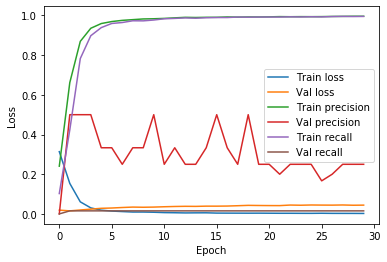

In [213]:
plot_loss(history_2_10000)

In [214]:
def get_model_47_3():
    output_bias = tf.keras.initializers.Constant(init_bias)
    
    inp_img = Input(shape=(1024,))
    x_img = Dense(512, activation='relu')(inp_img)
    x_img = Dropout(0.5)(x_img)
    x_img = Dense(512, activation='relu')(x_img)
    x_img = Dropout(0.5)(x_img)
    
    inp_txt = Input(shape=(300,))
    x_txt = Dense(256, activation='relu')(inp_txt)
    x_txt = Dropout(0.5)(x_txt)
    x_txt = Dense(256, activation='relu')(inp_txt)
    x_txt = Dropout(0.5)(x_txt)
    
    x = concatenate([x_img, x_txt])
    x = Dense(128)(x)
    x = Dropout(0.5)(x)
    x = concatenate([x, x_img, x_txt])
    x = Dense(128)(x)
    x = Dropout(0.5)(x)
    out = Dense(1, activation='sigmoid',  bias_initializer=output_bias)(x)

    model = Model(inputs=[inp_img, inp_txt], outputs=out)
    model.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-3), loss='binary_crossentropy', metrics=METRICS)
    return model

In [216]:
model_3_up_10000 = get_model_47_3()
history_3_10000 = model_3_up_10000.fit(
    [x_img_train_up, x_txt_train_up],
    y_train_up,
    batch_size=4096,
    validation_data=([x_img_val, x_txt_val], y_val_47),
    epochs=30
)

Train on 145417 samples, validate on 33975 samples
Epoch 1/30
145417/145417 [==============================] - 18s 124us/sample - loss: 0.5335 - tp: 937.0000 - fp: 5772.0000 - tn: 129785.0000 - fn: 8923.0000 - accuracy: 0.8989 - precision: 0.1397 - recall: 0.0950 - auc: 0.6093 - val_loss: 0.0287 - val_tp: 0.0000e+00 - val_fp: 1.0000 - val_tn: 33909.0000 - val_fn: 65.0000 - val_accuracy: 0.9981 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.7141
Epoch 2/30
145417/145417 [==============================] - 14s 95us/sample - loss: 0.2014 - tp: 1996.0000 - fp: 1963.0000 - tn: 133594.0000 - fn: 7864.0000 - accuracy: 0.9324 - precision: 0.5042 - recall: 0.2024 - auc: 0.8402 - val_loss: 0.0234 - val_tp: 1.0000 - val_fp: 3.0000 - val_tn: 33907.0000 - val_fn: 64.0000 - val_accuracy: 0.9980 - val_precision: 0.2500 - val_recall: 0.0154 - val_auc: 0.7076
Epoch 3/30
145417/145417 [==============================] - 16s 109us/sample - loss: 0.1224 - tp: 4803.0000 - fp: 1674.0000 - t

145417/145417 [==============================] - 20s 136us/sample - loss: 0.0035 - tp: 9767.0000 - fp: 76.0000 - tn: 135481.0000 - fn: 93.0000 - accuracy: 0.9988 - precision: 0.9923 - recall: 0.9906 - auc: 0.9997 - val_loss: 0.0395 - val_tp: 1.0000 - val_fp: 2.0000 - val_tn: 33908.0000 - val_fn: 64.0000 - val_accuracy: 0.9981 - val_precision: 0.3333 - val_recall: 0.0154 - val_auc: 0.5149
Epoch 22/30
145417/145417 [==============================] - 16s 107us/sample - loss: 0.0033 - tp: 9788.0000 - fp: 63.0000 - tn: 135494.0000 - fn: 72.0000 - accuracy: 0.9991 - precision: 0.9936 - recall: 0.9927 - auc: 0.9999 - val_loss: 0.0407 - val_tp: 1.0000 - val_fp: 3.0000 - val_tn: 33907.0000 - val_fn: 64.0000 - val_accuracy: 0.9980 - val_precision: 0.2500 - val_recall: 0.0154 - val_auc: 0.5074
Epoch 23/30
145417/145417 [==============================] - 15s 106us/sample - loss: 0.0032 - tp: 9782.0000 - fp: 64.0000 - tn: 135493.0000 - fn: 78.0000 - accuracy: 0.9990 - precision: 0.9935 - recall: 0.

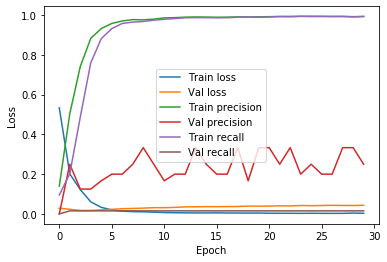

In [217]:
plot_loss(history_3_10000)

In [218]:
def get_model_47_4():
    output_bias = tf.keras.initializers.Constant(init_bias)
    
    inp_img = Input(shape=(1024,))
    x_img = Dense(512, activation='relu')(inp_img)
    x_img = Dropout(0.5)(x_img)
    
    relu = Dense(512, activation='relu')(x_img)
    sigmoid = Dense(512, activation='sigmoid')(x_img)
    mult_1 = Multiply()([x_img, sigmoid])
    minus = Lambda(lambda x: 1.0 - x)(sigmoid)
    mult_2 = Multiply()([minus, relu])
    x_img = Add()([mult_2, mult_1])
    x_img = Dropout(0.5)(x_img)
                                    
    
    inp_txt = Input(shape=(300,))
    x_txt = Dense(256, activation='relu')(inp_txt)
    x_txt = Dropout(0.5)(x_txt)
    
    relu = Dense(256, activation='relu')(x_txt)
    sigmoid = Dense(256, activation='sigmoid')(x_txt)
    mult_1 = Multiply()([x_txt, sigmoid])
    minus = Lambda(lambda x: 1.0 - x)(sigmoid)
    mult_2 = Multiply()([minus, relu])
    x_txt = Add()([mult_2, mult_1])
    x_txt = Dropout(0.5)(x_txt)
    
    x = concatenate([x_img, x_txt])
    
    x = Dense(256, activation='relu')(x)
    relu = Dense(256, activation='relu')(x)
    sigmoid = Dense(256, activation='sigmoid')(x)
    mult_1 = Multiply()([x, sigmoid])
    minus = Lambda(lambda x: 1.0 - x)(sigmoid)
    mult_2 = Multiply()([minus, relu])
    x = Add()([mult_2, mult_1])
    x = Dense(128)(x)
    
    x = Dropout(0.5)(x)
    out = Dense(1, activation='sigmoid',  bias_initializer=output_bias)(x)

    model = Model(inputs=[inp_img, inp_txt], outputs=out)
    model.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-3), loss='binary_crossentropy', metrics=METRICS)
    return model

In [221]:
model_4_up_10000 = get_model_47_4()
history_4_10000 = model_4_up_10000.fit(
    [x_img_train_up, x_txt_train_up],
    y_train_up,
    batch_size=4096,
    validation_data=([x_img_val, x_txt_val], y_val_47),
    epochs=30
)

Train on 145417 samples, validate on 33975 samples
Epoch 1/30
145417/145417 [==============================] - 32s 221us/sample - loss: 0.2620 - tp: 528.0000 - fp: 1235.0000 - tn: 134322.0000 - fn: 9332.0000 - accuracy: 0.9273 - precision: 0.2995 - recall: 0.0535 - auc: 0.6504 - val_loss: 0.0217 - val_tp: 0.0000e+00 - val_fp: 1.0000 - val_tn: 33909.0000 - val_fn: 65.0000 - val_accuracy: 0.9981 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.7066
Epoch 2/30
145417/145417 [==============================] - 24s 163us/sample - loss: 0.1502 - tp: 3342.0000 - fp: 1050.0000 - tn: 134507.0000 - fn: 6518.0000 - accuracy: 0.9480 - precision: 0.7609 - recall: 0.3389 - auc: 0.9132 - val_loss: 0.0137 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 33910.0000 - val_fn: 65.0000 - val_accuracy: 0.9981 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5827
Epoch 3/30
145417/145417 [==============================] - 24s 165us/sample - loss: 0.0666 - tp: 7421.0000 - 

145417/145417 [==============================] - 22s 150us/sample - loss: 0.0034 - tp: 9781.0000 - fp: 64.0000 - tn: 135493.0000 - fn: 79.0000 - accuracy: 0.9990 - precision: 0.9935 - recall: 0.9920 - auc: 0.9998 - val_loss: 0.0332 - val_tp: 1.0000 - val_fp: 2.0000 - val_tn: 33908.0000 - val_fn: 64.0000 - val_accuracy: 0.9981 - val_precision: 0.3333 - val_recall: 0.0154 - val_auc: 0.5076
Epoch 22/30
145417/145417 [==============================] - 22s 153us/sample - loss: 0.0032 - tp: 9784.0000 - fp: 63.0000 - tn: 135494.0000 - fn: 76.0000 - accuracy: 0.9990 - precision: 0.9936 - recall: 0.9923 - auc: 0.9998 - val_loss: 0.0341 - val_tp: 1.0000 - val_fp: 1.0000 - val_tn: 33909.0000 - val_fn: 64.0000 - val_accuracy: 0.9981 - val_precision: 0.5000 - val_recall: 0.0154 - val_auc: 0.5076
Epoch 23/30
145417/145417 [==============================] - 22s 152us/sample - loss: 0.0032 - tp: 9795.0000 - fp: 58.0000 - tn: 135499.0000 - fn: 65.0000 - accuracy: 0.9992 - precision: 0.9941 - recall: 0.

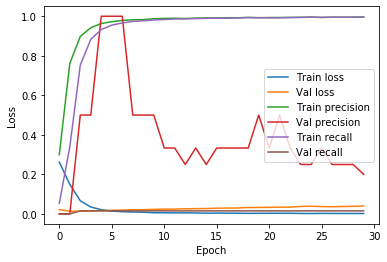

In [222]:
plot_loss(history_4_10000)